In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import re

In [2]:
df = pd.read_csv('/Users/nandipatioohasripriya/Downloads/QVI_data.csv', header= 0,
                     index_col= False)

In [3]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# Verify conversion to datetime
print(df['DATE'].dtype)

# Extract year and month as yyyymm
df['YearMonth'] = df['DATE'].dt.strftime('%Y%m')

df

datetime64[ns]


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YearMonth
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810


In [5]:
measure_summary = df.groupby(['STORE_NBR', 'YearMonth']).agg(
    total_sales=('TOT_SALES', 'sum'),
    number_of_customers=('LYLTY_CARD_NBR', pd.Series.nunique),
    total_transactions=('TXN_ID', 'count'),
    total_chips=('PROD_QTY', 'sum')
).reset_index()
measure_summary

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips
0,1,201807,206.9,49,52,62
1,1,201808,176.1,42,43,54
2,1,201809,278.8,59,62,75
3,1,201810,188.1,44,45,58
4,1,201811,192.6,46,47,57
...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91
3165,272,201903,442.3,50,53,101
3166,272,201904,445.1,54,56,105
3167,272,201905,314.6,34,40,71


In [6]:
# Calculate transactions per customer and chips per customer
measure_summary['transactions_per_customer'] = measure_summary['total_transactions'] / measure_summary['number_of_customers']
measure_summary['chips_per_customer'] = measure_summary['total_chips'] / measure_summary['number_of_customers']

# Merge back with the original DataFrame to get the average price per unit
df_merged = pd.merge(df, measure_summary, on=['STORE_NBR', 'YearMonth'])

In [7]:
# Calculate average price per unit
df_merged['avg_price_per_unit'] = df_merged['TOT_SALES'] / df_merged['PROD_QTY']

# Calculate average price per unit by store and month
avg_price_per_unit_summary = df_merged.groupby(['STORE_NBR', 'YearMonth'])['avg_price_per_unit'].mean().reset_index()

# Merge back to get the final summary
final_summary = pd.merge(measure_summary, avg_price_per_unit_summary, on=['STORE_NBR', 'YearMonth'])

# Display the final summary
final_summary

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766
...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500


In [8]:
final_summary['YearMonth'] = final_summary['YearMonth'].astype(int)
stores_with_full_obs = final_summary.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

# Filter to pre-trial period and stores with full observation periods
pre_trial_measures = final_summary[(final_summary['YearMonth'] < 201902) & (final_summary['STORE_NBR'].isin(stores_with_full_obs))]


In [9]:
def calculate_correlation(input_table, metric_col, store_comparison):
    # Initialize an empty DataFrame to store the results
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    
    # Get the list of store numbers excluding the trial store
    store_numbers = input_table[input_table['STORE_NBR'] != store_comparison]['STORE_NBR'].unique()
    
    # Loop through each control store
    for store in store_numbers:
        # Extract the metric data for the trial store and the current control store
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison].set_index('YearMonth')[metric_col]
        control_store_data = input_table[input_table['STORE_NBR'] == store].set_index('YearMonth')[metric_col]
        
        # Calculate the correlation between the trial store and the control store
        correlation = trial_store_data.corr(control_store_data)
        
        # Create a DataFrame with the calculated measure
        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [store],
            'corr_measure': [correlation]
        })
        
        # Append the calculated measure to the results table
        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)
    
    # Return the results table
    return calc_corr_table


In [10]:
corr_total_sales = calculate_correlation(pre_trial_measures, 'total_sales', 77)
corr_number_of_customers = calculate_correlation(pre_trial_measures, 'number_of_customers', 77)

# Print the results
print("Correlation with Total Sales:")
print(corr_total_sales)
print("\nCorrelation with Number of Customers:")
print(corr_number_of_customers)

Correlation with Total Sales:
    Store1 Store2  corr_measure
0       77      1      0.075218
1       77      2     -0.263079
2       77      3      0.806644
3       77      4     -0.263300
4       77      5     -0.110652
..     ...    ...           ...
254     77    268      0.344757
255     77    269     -0.315730
256     77    270      0.315430
257     77    271      0.355487
258     77    272      0.117622

[259 rows x 3 columns]

Correlation with Number of Customers:
    Store1 Store2  corr_measure
0       77      1      0.322168
1       77      2     -0.572051
2       77      3      0.834207
3       77      4     -0.295639
4       77      5      0.370659
..     ...    ...           ...
254     77    268      0.369517
255     77    269     -0.474293
256     77    270     -0.131259
257     77    271      0.019629
258     77    272      0.223217

[259 rows x 3 columns]


In [11]:
score_nSales = corr_total_sales.copy()
score_nSales.columns = ['Store1', 'Store2', 'scoreNSales']

score_nCustomers = corr_number_of_customers.copy()
score_nCustomers.columns = ['Store1', 'Store2', 'scoreNCust']

# Combine scores across the drivers by first merging our sales scores and customer scores into a single table
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])

# Calculate the final control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Print the final scores
print(score_Control)

# Select the control store with the highest score
best_control_store = score_Control.loc[score_Control['finalControlScore'].idxmax()]
print("Best control store:")
best_control_store

    Store1 Store2  scoreNSales  scoreNCust  finalControlScore
0       77      1     0.075218    0.322168           0.198693
1       77      2    -0.263079   -0.572051          -0.417565
2       77      3     0.806644    0.834207           0.820426
3       77      4    -0.263300   -0.295639          -0.279469
4       77      5    -0.110652    0.370659           0.130003
..     ...    ...          ...         ...                ...
254     77    268     0.344757    0.369517           0.357137
255     77    269    -0.315730   -0.474293          -0.395011
256     77    270     0.315430   -0.131259           0.092086
257     77    271     0.355487    0.019629           0.187558
258     77    272     0.117622    0.223217           0.170420

[259 rows x 5 columns]
Best control store:


Store1                     77
Store2                    233
scoreNSales          0.903774
scoreNCust           0.990358
finalControlScore    0.947066
Name: 220, dtype: object

In [12]:
measure_over_time_sales = final_summary.copy()
#visualization for total sales
def sales_for_TrailControlOther_stores(trial_store , control_store , col):

    # Label the store types
    measure_over_time_sales['Store_type'] = measure_over_time_sales['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
    )

    # Calculate the mean total sales by month and store type
    past_sales = measure_over_time_sales.groupby(['YearMonth', 'Store_type']).agg({col: 'mean'}).reset_index()

    # Convert YearMonth to a datetime format
    past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YearMonth'].astype(str) + '01', format='%Y%m%d')

    # Filter to pre-trial period
    past_sales = past_sales[past_sales['YearMonth'] < 201903]
    print(past_sales)

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=past_sales, x='TransactionMonth', y=col, hue='Store_type')
    plt.xlabel('Month of Operation')
    plt.ylabel(col)
    plt.title(f'{col} by Month for Trail , Control , Other Stores')
    plt.show()

    YearMonth    Store_type  total_sales TransactionMonth
0      201807       Control   290.700000       2018-07-01
1      201807  Other stores   623.817424       2018-07-01
2      201807         Trial   296.800000       2018-07-01
3      201808       Control   285.900000       2018-08-01
4      201808  Other stores   603.600192       2018-08-01
5      201808         Trial   255.500000       2018-08-01
6      201809       Control   228.600000       2018-09-01
7      201809  Other stores   610.947328       2018-09-01
8      201809         Trial   225.200000       2018-09-01
9      201810       Control   185.700000       2018-10-01
10     201810  Other stores   623.671103       2018-10-01
11     201810         Trial   204.500000       2018-10-01
12     201811       Control   211.600000       2018-11-01
13     201811  Other stores   609.835115       2018-11-01
14     201811         Trial   245.300000       2018-11-01
15     201812       Control   279.800000       2018-12-01
16     201812 

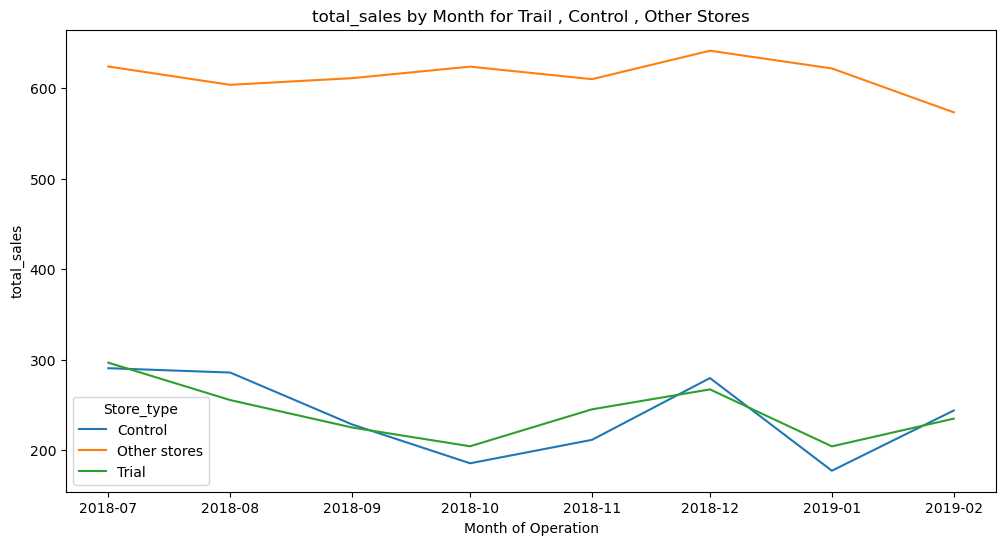

In [13]:
sales_for_TrailControlOther_stores(77 , 233 , 'total_sales')

    YearMonth    Store_type  number_of_customers TransactionMonth
0      201807       Control            51.000000       2018-07-01
1      201807  Other stores            70.750000       2018-07-01
2      201807         Trial            51.000000       2018-07-01
3      201808       Control            48.000000       2018-08-01
4      201808  Other stores            71.352490       2018-08-01
5      201808         Trial            47.000000       2018-08-01
6      201809       Control            42.000000       2018-09-01
7      201809  Other stores            69.110687       2018-09-01
8      201809         Trial            42.000000       2018-09-01
9      201810       Control            35.000000       2018-10-01
10     201810  Other stores            70.334601       2018-10-01
11     201810         Trial            37.000000       2018-10-01
12     201811       Control            40.000000       2018-11-01
13     201811  Other stores            69.534351       2018-11-01
14     201

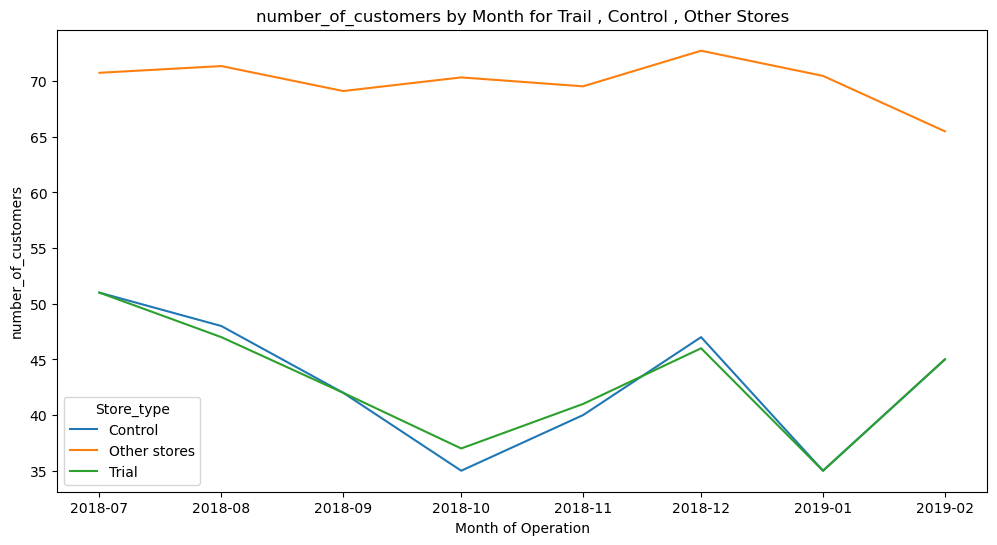

In [14]:
sales_for_TrailControlOther_stores(77 , 233 , 'number_of_customers')

In [15]:
#function for scaling the control store for sales column
def calculate_scaling_factor( trial_store, control_store, col):

    # Calculate pre-trial total sales for trial store
    pre_trial_trial_store_sales = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == trial_store) & (measure_over_time_sales['YearMonth'] < 201902)][col].sum()

    # Calculate pre-trial total sales for control store
    pre_trial_control_store_sales = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == control_store) & (measure_over_time_sales['YearMonth'] < 201902)][col].sum()

    # Calculate scaling factor
    scaling_factor = pre_trial_trial_store_sales / pre_trial_control_store_sales

    return scaling_factor

In [16]:
trial_store = 77
control_store = 233
col = 'total_sales'
# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store, col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 1.023617303289553


In [17]:
#Applying scaling factor to the control store.
measure_over_time_sales['scaledControlSales'] = measure_over_time_sales.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == control_store else row['total_sales'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6
...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6


In [18]:
def t_value(data, trial_store, control_store, trial_sales, control_sales):
    # Filter data for the trial period (February 2019 to April 2019)
    trial_period_data = data[(data['YearMonth'] >= 201902) & (data['YearMonth'] <= 201904)]
    
    # Separate data for trial store and scaled control store
    trial_store_sales = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]
    scaled_control_store_sales = trial_period_data[trial_period_data['STORE_NBR'] == control_store]

    # Filter data for pre-trial period (before February 2019)
    pre_trial_data = data[data['YearMonth'] < 201902]

    # Merge data on 'YearMonth' for pre-trial
    pre_trial_comparison_df = pd.merge(
        pre_trial_data[pre_trial_data['STORE_NBR'] == control_store][['YearMonth', control_sales]],
        pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store][[trial_sales, 'YearMonth']],
        on='YearMonth'
    )
    pre_trial_comparison_df['percentageDiff'] = abs(pre_trial_comparison_df[control_sales] - pre_trial_comparison_df[trial_sales]) / pre_trial_comparison_df[control_sales]

    # Calculate standard deviation of percentage differences in pre-trial period
    std_dev = np.std(pre_trial_comparison_df['percentageDiff'])
    print(f"Standard Deviation: {std_dev}")

    # Degrees of freedom (8 months in pre-trial period, hence 8 - 1 = 7)
    degrees_of_freedom = 7

    # Merge data on 'YearMonth' for trial period
    trial_comparison_df = pd.merge(
        scaled_control_store_sales[['YearMonth', control_sales]],
        trial_store_sales[['YearMonth', trial_sales]],
        on='YearMonth'
    )
    trial_comparison_df['percentageDiff'] = abs(trial_comparison_df[control_sales] - trial_comparison_df[trial_sales]) / trial_comparison_df[control_sales]

    # Calculate t-values for the trial months using the trial_comparison_df
    trial_comparison_df['tValue'] = (trial_comparison_df['percentageDiff'] - 0) / std_dev
    trial_comparison_df['TransactionMonth'] = pd.to_datetime(trial_comparison_df['YearMonth'].astype(str) + '01', format='%Y%m%d')

    print(trial_comparison_df[['TransactionMonth', 'percentageDiff', 'tValue']])

    # Find the critical t-value for the 95th percentile
    critical_t_value = t.ppf(0.95, degrees_of_freedom)
    print(f"Critical t-value (95th percentile): {critical_t_value}")

    # Check if the t-values exceed the critical value
    trial_comparison_df['Significant'] = trial_comparison_df['tValue'] > critical_t_value

    return trial_comparison_df

In [19]:
result = t_value(measure_over_time_sales, 77, 233, 'total_sales', 'scaledControlSales')
result

Standard Deviation: 0.046236161851401746
  TransactionMonth  percentageDiff     tValue
0       2019-02-01        0.059107   1.278363
1       2019-03-01        0.366521   7.927151
2       2019-04-01        0.623080  13.476023
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlSales,total_sales,percentageDiff,tValue,TransactionMonth,Significant
0,201902,249.762622,235.0,0.059107,1.278363,2019-02-01,False
1,201903,203.802205,278.5,0.366521,7.927151,2019-03-01,True
2,201904,162.345704,263.5,0.623080,13.476023,2019-04-01,True


In [20]:
def t_value_vis( trial_store, control_store, std_dev, col):
    # Step 1: Group data by YearMonth and Store_type, then calculate mean of the specified column
    past_sales = measure_over_time_sales.groupby(['YearMonth', 'Store_type'])[col].mean().reset_index()
    past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YearMonth'].astype(str) + '01', format='%Y%m%d')

    # Step 2: Filter for trial and control stores only
    past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

    # Step 3: Calculate 95th percentile for control store sales
    control_sales_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
    control_sales_95[col] = control_sales_95[col] * (1 + std_dev * 2)
    control_sales_95['Store_type'] = 'Control 95th % confidence interval'

    # Step 4: Calculate 5th percentile for control store sales
    control_sales_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
    control_sales_5[col] = control_sales_5[col] * (1 - std_dev * 2)
    control_sales_5['Store_type'] = 'Control 5th % confidence interval'

    # Step 5: Combine all data into a single DataFrame
    trial_assessment = pd.concat([past_sales, control_sales_95, control_sales_5])

    # Step 6: Plot the data
    plt.figure(figsize=(14, 7))

    # Highlight the trial period
    plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='gray', alpha=0.3, label='Trial Period')

    # Plot the sales data
    sns.lineplot(data=trial_assessment, x='TransactionMonth', y=col, hue='Store_type')

    # Add labels and title
    plt.xlabel('Month of Operation')
    plt.ylabel(col)
    plt.title(f'{col} by Month')
    plt.legend()
    plt.show()

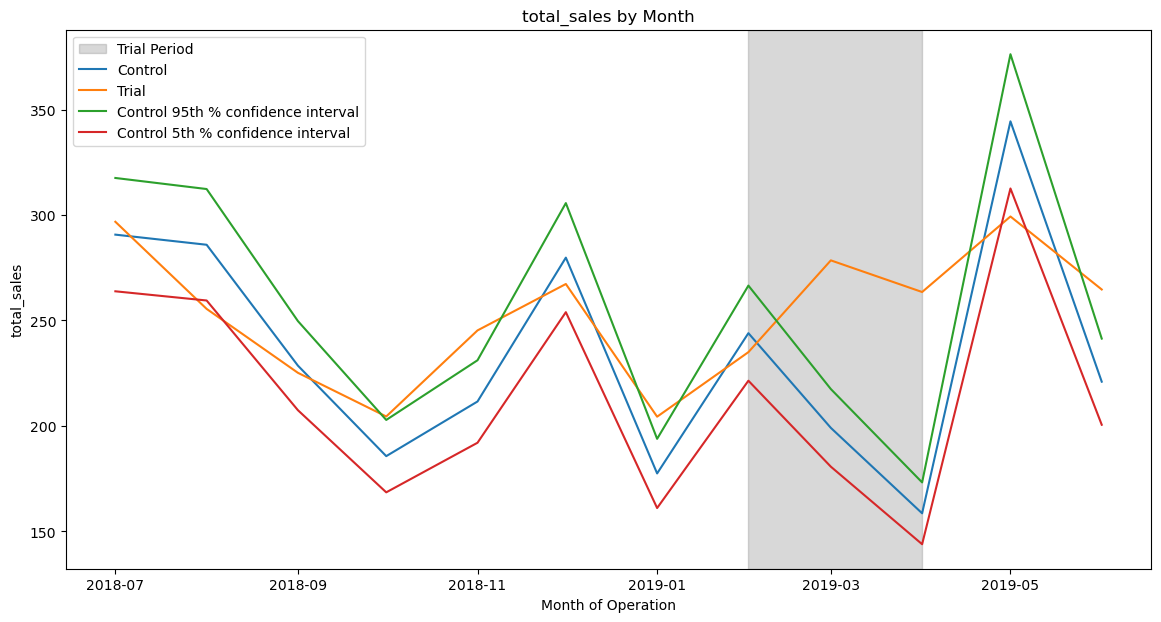

In [21]:
t_value_vis(77, 233, 0.0462, 'total_sales')
# The results show that the trial in store 77 is significantly different to its control store in the trial period as
# the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
# three trial months.

In [22]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers

trial_store = 77
control_store = 233
col = 'number_of_customers'

# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store, col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 1.0033557046979866


In [23]:
#Applying scaling factor to the control store for customers column.
measure_over_time_sales['scaledControlCustomers'] = measure_over_time_sales.apply(
    lambda row: row['number_of_customers'] * scaling_factor if row['STORE_NBR'] == control_store else row['number_of_customers'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales,scaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9,49.0
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1,42.0
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8,59.0
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1,44.0
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5,45.0
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3,50.0
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1,54.0
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6,34.0


In [24]:
result = t_value(measure_over_time_sales, 77, 233, 'number_of_customers', 'scaledControlCustomers')
result

Standard Deviation: 0.016887651650119434
  TransactionMonth  percentageDiff     tValue
0       2019-02-01        0.003344   0.198043
1       2019-03-01        0.245819  14.556162
2       2019-04-01        0.561427  33.244822
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlCustomers,number_of_customers,percentageDiff,tValue,TransactionMonth,Significant
0,201902,45.151007,45,0.003344,0.198043,2019-02-01,False
1,201903,40.134228,50,0.245819,14.556162,2019-03-01,True
2,201904,30.100671,47,0.561427,33.244822,2019-04-01,True


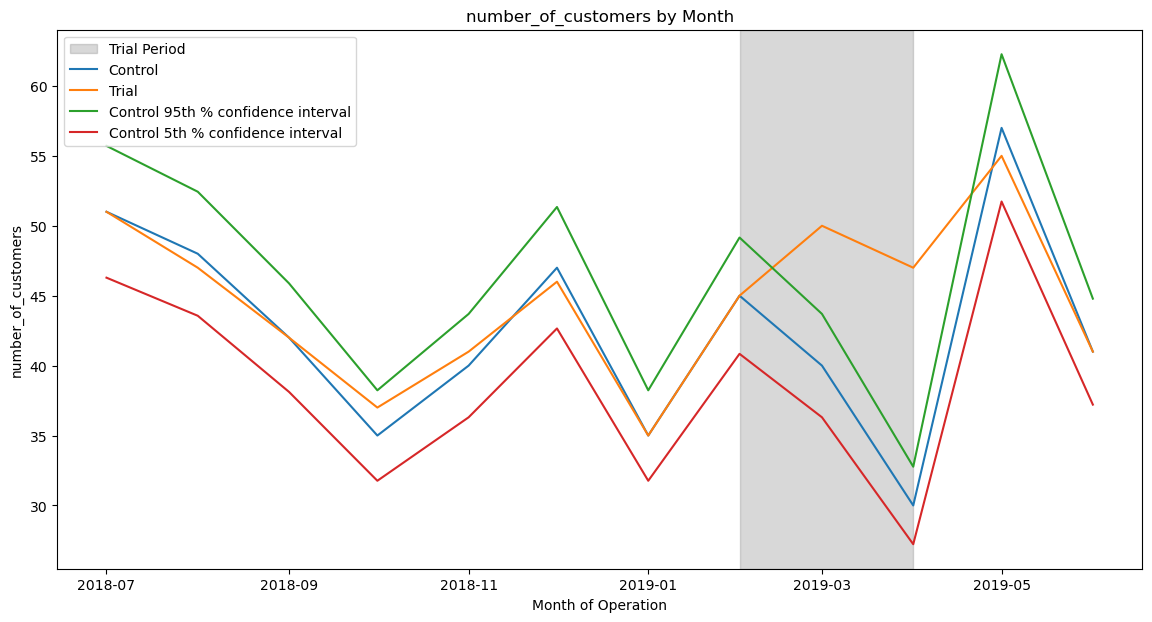

In [25]:
#lets visualize this graphically to observe the increase in sales for two in three months
t_value_vis(77, 233, 0.0462, 'number_of_customers')

#The results show that the trial in store 77 is significantly different to its control store in the trial period as
#the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
#three trial months.

In [26]:
#repeat the process above for store 86.
corr_total_sales = calculate_correlation(pre_trial_measures, 'total_sales', 86)
corr_number_of_customers = calculate_correlation(pre_trial_measures, 'number_of_customers', 86)

# Print the results
print("Correlation with Total Sales:")
print(corr_total_sales)
print("\nCorrelation with Number of Customers:")
print(corr_number_of_customers)

Correlation with Total Sales:
    Store1 Store2  corr_measure
0       86      1      0.445632
1       86      2     -0.403835
2       86      3     -0.261284
3       86      4     -0.039035
4       86      5      0.235159
..     ...    ...           ...
254     86    268     -0.452182
255     86    269      0.697055
256     86    270     -0.730679
257     86    271      0.527637
258     86    272      0.004926

[259 rows x 3 columns]

Correlation with Number of Customers:
    Store1 Store2  corr_measure
0       86      1      0.485831
1       86      2     -0.086161
2       86      3     -0.353786
3       86      4     -0.169608
4       86      5     -0.253229
..     ...    ...           ...
254     86    268     -0.034273
255     86    269     -0.098587
256     86    270     -0.767267
257     86    271      0.267393
258     86    272     -0.353815

[259 rows x 3 columns]


In [27]:
score_nSales = corr_total_sales
score_nSales.columns = ['Store1', 'Store2', 'scoreNSales']

score_nCustomers = corr_number_of_customers.copy()
score_nCustomers.columns = ['Store1', 'Store2', 'scoreNCust']

# Combine scores across the drivers by first merging our sales scores and customer scores into a single table
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])

# Calculate the final control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Print the final scores
print(score_Control)

# Select the control store with the highest score
best_control_store = score_Control.loc[score_Control['finalControlScore'].idxmax()]
print("Best control store:")
best_control_store

    Store1 Store2  scoreNSales  scoreNCust  finalControlScore
0       86      1     0.445632    0.485831           0.465731
1       86      2    -0.403835   -0.086161          -0.244998
2       86      3    -0.261284   -0.353786          -0.307535
3       86      4    -0.039035   -0.169608          -0.104322
4       86      5     0.235159   -0.253229          -0.009035
..     ...    ...          ...         ...                ...
254     86    268    -0.452182   -0.034273          -0.243228
255     86    269     0.697055   -0.098587           0.299234
256     86    270    -0.730679   -0.767267          -0.748973
257     86    271     0.527637    0.267393           0.397515
258     86    272     0.004926   -0.353815          -0.174445

[259 rows x 5 columns]
Best control store:


Store1                     86
Store2                    155
scoreNSales          0.877882
scoreNCust           0.942876
finalControlScore    0.910379
Name: 146, dtype: object

    YearMonth    Store_type  total_sales TransactionMonth
0      201807       Control   924.600000       2018-07-01
1      201807  Other stores   619.160985       2018-07-01
2      201807         Trial   892.200000       2018-07-01
3      201808       Control   782.700000       2018-08-01
4      201808  Other stores   599.748276       2018-08-01
5      201808         Trial   764.050000       2018-08-01
6      201809       Control  1014.400000       2018-09-01
7      201809  Other stores   605.316794       2018-09-01
8      201809         Trial   914.600000       2018-09-01
9      201810       Control   963.800000       2018-10-01
10     201810  Other stores   617.884030       2018-10-01
11     201810         Trial   948.400000       2018-10-01
12     201811       Control   898.800000       2018-11-01
13     201811  Other stores   604.644656       2018-11-01
14     201811         Trial   918.000000       2018-11-01
15     201812       Control   849.800000       2018-12-01
16     201812 

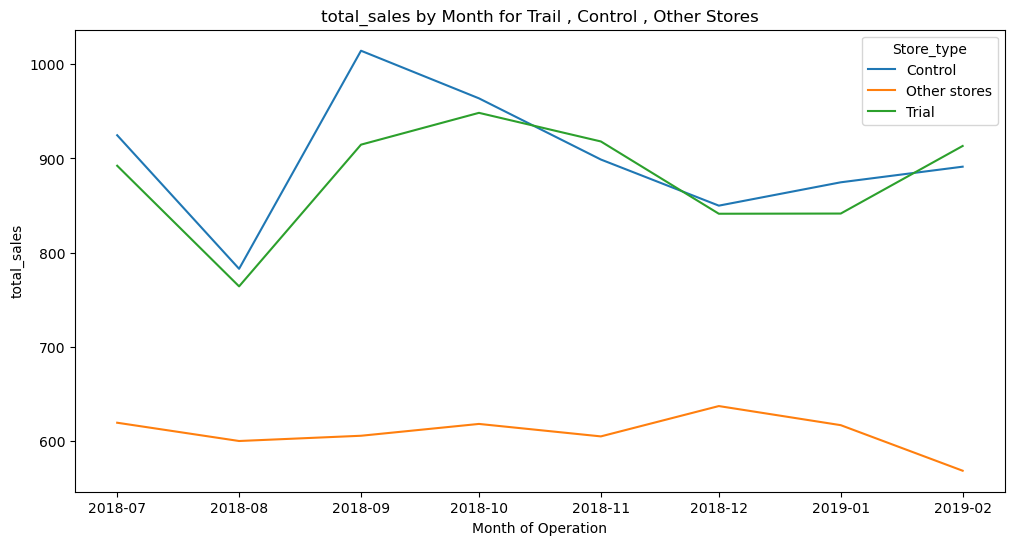

In [28]:
#lets see if the drivers are indeed same for trail and control store.
sales_for_TrailControlOther_stores(86 , 155 , 'total_sales')

    YearMonth    Store_type  number_of_customers TransactionMonth
0      201807       Control           101.000000       2018-07-01
1      201807  Other stores            70.378788       2018-07-01
2      201807         Trial            99.000000       2018-07-01
3      201808       Control            91.000000       2018-08-01
4      201808  Other stores            71.007663       2018-08-01
5      201808         Trial            94.000000       2018-08-01
6      201809       Control           103.000000       2018-09-01
7      201809  Other stores            68.645038       2018-09-01
8      201809         Trial           103.000000       2018-09-01
9      201810       Control           108.000000       2018-10-01
10     201810  Other stores            69.783270       2018-10-01
11     201810         Trial           109.000000       2018-10-01
12     201811       Control           101.000000       2018-11-01
13     201811  Other stores            69.076336       2018-11-01
14     201

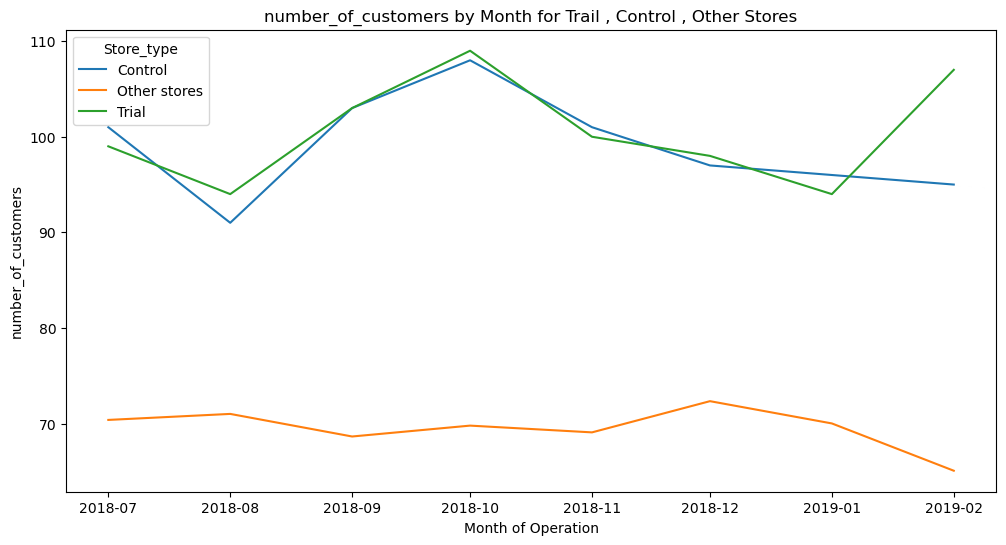

In [29]:
sales_for_TrailControlOther_stores(86 , 155 , 'number_of_customers')

In [30]:
#finding the scaling factor.
trial_store = 86
control_store = 155
col = 'total_sales'
# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store,col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 0.9700651481287743


In [31]:
#Applying scaling factor to the control store.
measure_over_time_sales['scaledControlSales'] = measure_over_time_sales.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == control_store else row['total_sales'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales,scaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9,49.0
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1,42.0
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8,59.0
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1,44.0
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5,45.0
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3,50.0
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1,54.0
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6,34.0


In [32]:
#calculating the t-value to check if they are significantly different in trail peroid.
result = t_value(measure_over_time_sales, 86, 155, 'total_sales', 'scaledControlSales')
result

Standard Deviation: 0.023917592809524744
  TransactionMonth  percentageDiff     tValue
0       2019-02-01        0.056306   2.354174
1       2019-03-01        0.315870  13.206585
2       2019-04-01        0.035253   1.473915
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlSales,total_sales,percentageDiff,tValue,TransactionMonth,Significant
0,201902,864.522060,913.2,0.056306,2.354174,2019-02-01,True
1,201903,780.320405,1026.8,0.315870,13.206585,2019-03-01,True
2,201904,819.317024,848.2,0.035253,1.473915,2019-04-01,False


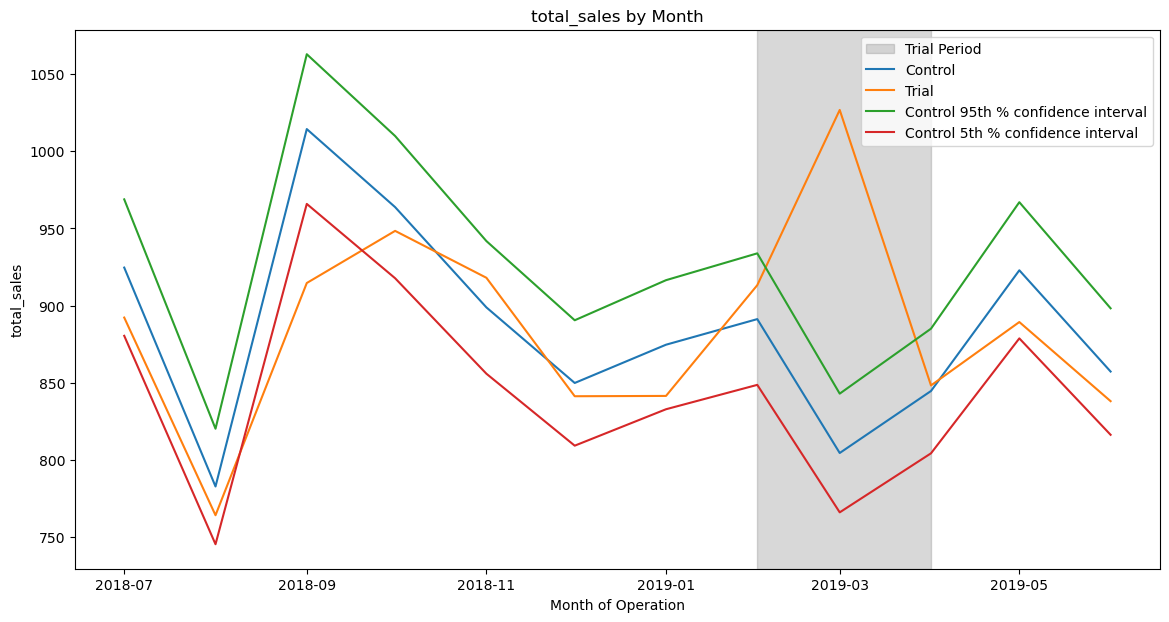

In [33]:
t_value_vis(86, 155, 0.023917592809524744, 'total_sales')
# The results show that the trial in store 86 is not significantly different to its control store in the trial period
# as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
# three trial months.

In [34]:
#### Scale pre‐trial control customers to match pre‐trial trial store customers for 86 & 155 stores

trial_store = 86
control_store = 155
col = 'number_of_customers'

# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store, col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 1.0


In [35]:
#Applying scaling factor to the control store.
measure_over_time_sales['scaledControlSales'] = measure_over_time_sales.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == control_store else row['total_sales'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales,scaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9,49.0
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1,42.0
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8,59.0
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1,44.0
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5,45.0
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3,50.0
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1,54.0
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6,34.0


In [36]:
#calculating the t-value to check if they are significantly different in trail peroid.
result = t_value(measure_over_time_sales, 86, 155, 'number_of_customers', 'scaledControlCustomers')
result

Standard Deviation: 0.009894651119759365
  TransactionMonth  percentageDiff     tValue
0       2019-02-01        0.126316  12.766068
1       2019-03-01        0.223404  22.578285
2       2019-04-01        0.060606   6.125134
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlCustomers,number_of_customers,percentageDiff,tValue,TransactionMonth,Significant
0,201902,95.0,107,0.126316,12.766068,2019-02-01,True
1,201903,94.0,115,0.223404,22.578285,2019-03-01,True
2,201904,99.0,105,0.060606,6.125134,2019-04-01,True


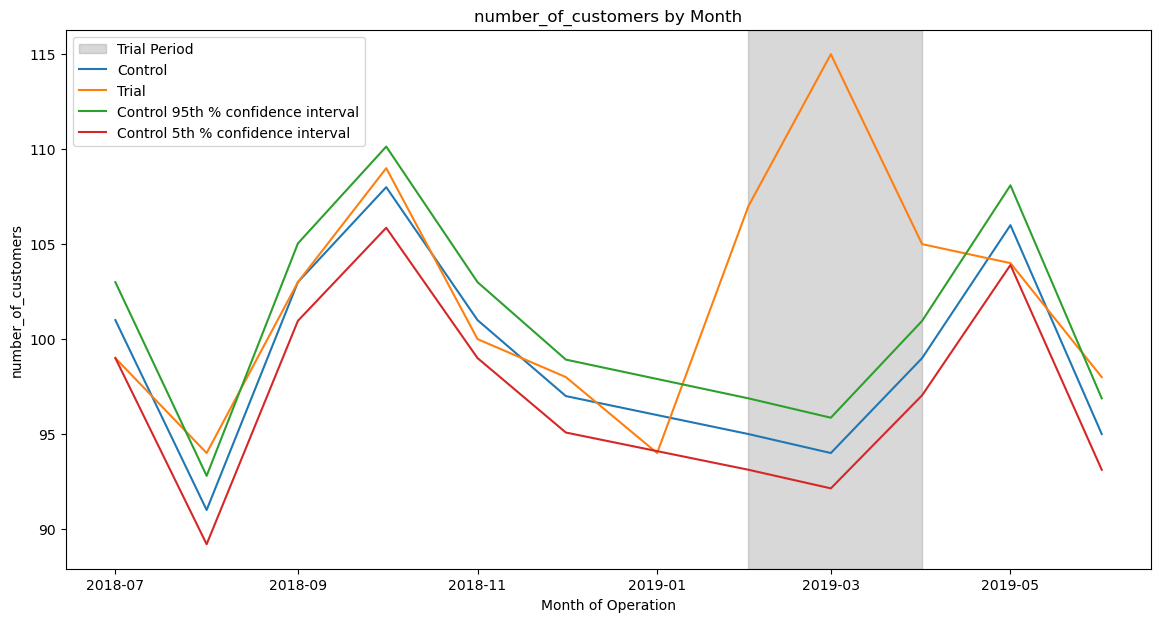

In [37]:
t_value_vis(86, 155, 0.0098946, 'number_of_customers')
# It looks like the number of customers is significantly higher in all of the three months. This seems to
# suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
# as we saw, sales were not significantly higher. We should check with the Category Manager if there were
# special deals in the trial store that were may have resulted in lower prices, impacting the results.

In [38]:
#lets do the same for store 88.
corr_total_sales = calculate_correlation(pre_trial_measures, 'total_sales', 88)
corr_number_of_customers = calculate_correlation(pre_trial_measures, 'number_of_customers', 88)

# Print the results
print("Correlation with Total Sales:")
print(corr_total_sales)
print("\nCorrelation with Number of Customers:")
print(corr_number_of_customers)

Correlation with Total Sales:
    Store1 Store2  corr_measure
0       88      1      0.813636
1       88      2     -0.067927
2       88      3     -0.507847
3       88      4     -0.745566
4       88      5      0.190330
..     ...    ...           ...
254     88    268     -0.021429
255     88    269     -0.172578
256     88    270     -0.723272
257     88    271     -0.103037
258     88    272     -0.772772

[259 rows x 3 columns]

Correlation with Number of Customers:
    Store1 Store2  corr_measure
0       88      1      0.305334
1       88      2     -0.452379
2       88      3      0.522884
3       88      4     -0.361503
4       88      5     -0.025320
..     ...    ...           ...
254     88    268      0.672672
255     88    269     -0.274781
256     88    270     -0.103032
257     88    271     -0.018831
258     88    272      0.026909

[259 rows x 3 columns]


In [39]:
df = pd.DataFrame(corr_number_of_customers)

# Find the row with the highest correlation value
highest_correlation = df.loc[df['corr_measure'].idxmax()]

print("Highest Correlation:")
print(highest_correlation)

Highest Correlation:
Store1                88
Store2               237
corr_measure    0.947326
Name: 224, dtype: object


    YearMonth    Store_type  total_sales TransactionMonth
0      201807       Control  1448.400000       2018-07-01
1      201807  Other stores   615.594318       2018-07-01
2      201807         Trial  1310.000000       2018-07-01
3      201808       Control  1367.800000       2018-08-01
4      201808  Other stores   595.361877       2018-08-01
5      201808         Trial  1323.800000       2018-08-01
6      201809       Control  1322.200000       2018-09-01
7      201809  Other stores   602.201527       2018-09-01
8      201809         Trial  1423.000000       2018-09-01
9      201810       Control  1348.300000       2018-10-01
10     201810  Other stores   614.885932       2018-10-01
11     201810         Trial  1352.400000       2018-10-01
12     201811       Control  1397.600000       2018-11-01
13     201811  Other stores   600.966794       2018-11-01
14     201811         Trial  1382.800000       2018-11-01
15     201812       Control  1265.000000       2018-12-01
16     201812 

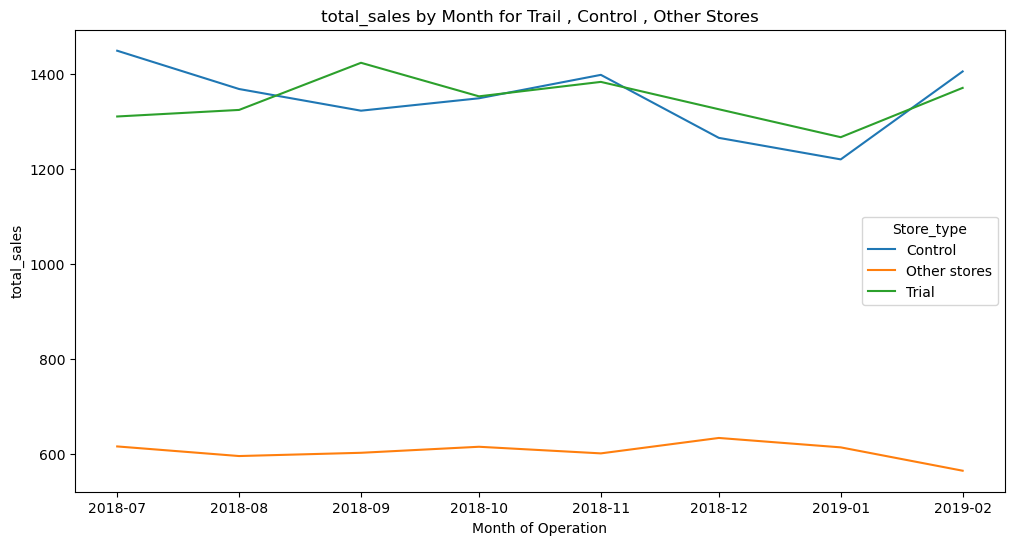

In [42]:
sales_for_TrailControlOther_stores(88 , 237 , 'total_sales')

    YearMonth    Store_type  number_of_customers TransactionMonth
0      201807       Control           128.000000       2018-07-01
1      201807  Other stores            70.162879       2018-07-01
2      201807         Trial           129.000000       2018-07-01
3      201808       Control           135.000000       2018-08-01
4      201808  Other stores            70.697318       2018-08-01
5      201808         Trial           131.000000       2018-08-01
6      201809       Control           126.000000       2018-09-01
7      201809  Other stores            68.477099       2018-09-01
8      201809         Trial           124.000000       2018-09-01
9      201810       Control           123.000000       2018-10-01
10     201810  Other stores            69.673004       2018-10-01
11     201810         Trial           123.000000       2018-10-01
12     201811       Control           132.000000       2018-11-01
13     201811  Other stores            68.843511       2018-11-01
14     201

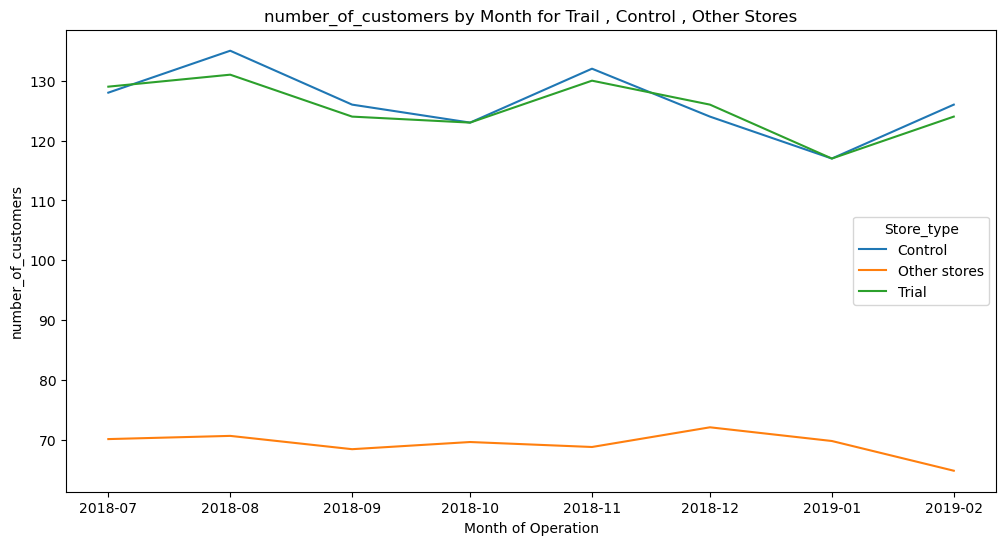

In [43]:
sales_for_TrailControlOther_stores(88 , 237 , 'number_of_customers')

In [44]:
#finding the scaling factor.
trial_store = 88
control_store = 237
col = 'total_sales'
# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store,col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 1.001558330664959


In [45]:
#Applying scaling factor to the control store.
measure_over_time_sales['scaledControlSales'] = measure_over_time_sales.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == control_store else row['total_sales'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales,scaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9,49.0
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1,42.0
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8,59.0
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1,44.0
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5,45.0
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3,50.0
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1,54.0
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6,34.0


In [46]:
#calculating the t-value to check if they are significantly different in trail peroid.
result = t_value(measure_over_time_sales, 88, 237, 'total_sales', 'scaledControlSales')
result

Standard Deviation: 0.030985224245710923
  TransactionMonth  percentageDiff    tValue
0       2019-02-01        0.026147  0.843868
1       2019-03-01        0.220743  7.124136
2       2019-04-01        0.193060  6.230721
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlSales,total_sales,percentageDiff,tValue,TransactionMonth,Significant
0,201902,1406.989143,1370.2,0.026147,0.843868,2019-02-01,False
1,201903,1210.082775,1477.2,0.220743,7.124136,2019-03-01,True
2,201904,1206.477165,1439.4,0.193060,6.230721,2019-04-01,True


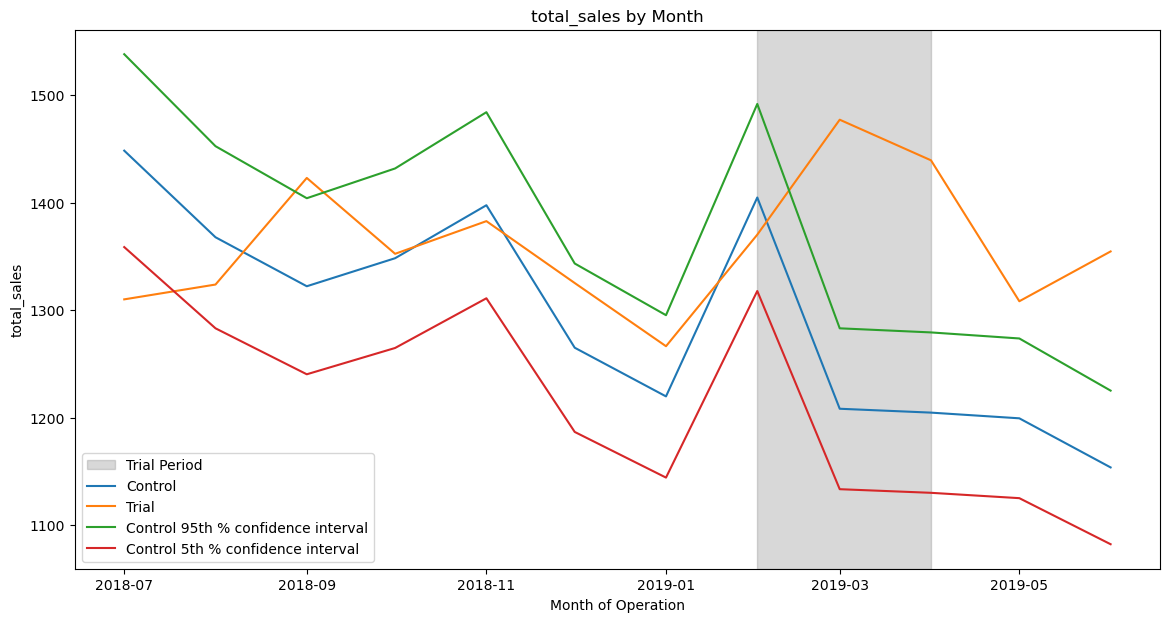

In [49]:
t_value_vis(88, 237, 0.03098, 'total_sales')
# The results show that the trial in store 88 is significantly different to its control store in the trial period as the
# trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
# three trial months.

In [50]:
#lets apply the same for customers

In [51]:
#finding the scaling factor.
trial_store = 88
control_store = 237
col = 'number_of_customers'
# Calculate the scaling factor
scaling_factor = calculate_scaling_factor( trial_store, control_store,col)
print(f"Scaling Factor: {scaling_factor}")

Scaling Factor: 0.9943502824858758


In [55]:
#Applying scaling factor to the control store.
measure_over_time_sales['scaledControlCustomers'] = measure_over_time_sales.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == control_store else row['total_sales'],
    axis=1
)
measure_over_time_sales

,STORE_NBR,YearMonth,total_sales,number_of_customers,total_transactions,total_chips,transactions_per_customer,chips_per_customer,avg_price_per_unit,Store_type,scaledControlSales,scaledControlCustomers
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.384615,Other stores,206.9,206.9
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.329070,Other stores,176.1,176.1
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.685484,Other stores,278.8,278.8
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.288889,Other stores,188.1,188.1
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.412766,Other stores,192.6,192.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.358333,Other stores,395.5,395.5
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.350943,Other stores,442.3,442.3
3166,272,201904,445.1,54,56,105,1.037037,1.944444,4.248214,Other stores,445.1,445.1
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.437500,Other stores,314.6,314.6


In [56]:
#calculating the t-value to check if they are significantly different in trail peroid.
result = t_value(measure_over_time_sales, 88, 237, 'number_of_customers', 'scaledControlCustomers')
result

Standard Deviation: 0.0032101085195648687
  TransactionMonth  percentageDiff      tValue
0       2019-02-01        0.911230  283.862578
1       2019-03-01        0.888461  276.769786
2       2019-04-01        0.893137  278.226393
Critical t-value (95th percentile): 1.894578605061305


,YearMonth,scaledControlCustomers,number_of_customers,percentageDiff,tValue,TransactionMonth,Significant
0,201902,1396.863277,124,0.911230,283.862578,2019-02-01,True
1,201903,1201.374011,134,0.888461,276.769786,2019-03-01,True
2,201904,1197.794350,128,0.893137,278.226393,2019-04-01,True


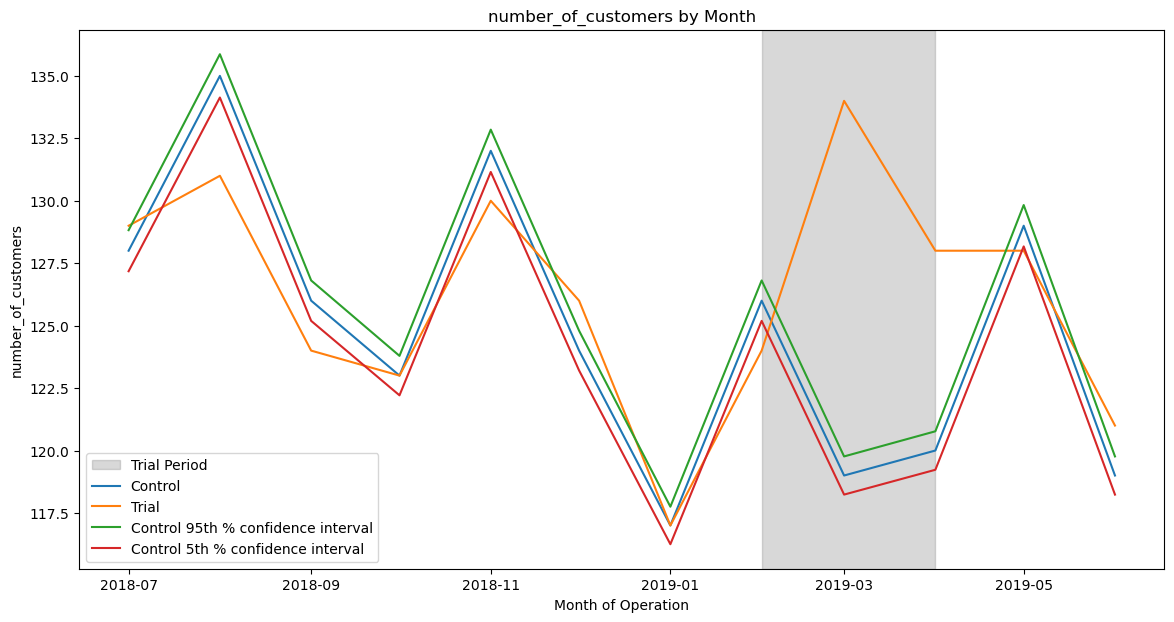

In [58]:
t_value_vis(88, 237, 0.00321, 'number_of_customers')
# Total number of customers in the trial period for the trial store is significantly higher than the control store
# for two out of three months, which indicates a positive trial effect.

In [59]:
# Conclusion
# We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
# The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
# three trial months but this is not the case for trial store 86. We can check with the client if the implementation
# of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
# we have finished our analysis, we can prepare our presentation to the Category Manager.